In [1]:
!pip install -q datasets transformers

# ColPali model
source : <a href="https://huggingface.co/blog/manu/colpali">https://huggingface.co/blog/manu/colpali</a>

In [2]:
from datasets import load_dataset

dataset = load_dataset("davanstrien/ufo-ColPali")
dataset = dataset["train"]
dataset = dataset.filter(lambda example:example["specific_detail_query"] is not None)
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/293M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2243 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2243 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'raw_queries', 'broad_topical_query', 'broad_topical_explanation', 'specific_detail_query', 'specific_detail_explanation', 'visual_element_query', 'visual_element_explanation', 'parsed_into_json'],
    num_rows: 2172
})

In [3]:
!nvidia-smi

Wed Sep 24 05:57:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch
from transformers import ColPaliForRetrieval, ColPaliProcessor

In [5]:
model_name = "vidore/colpali-v1.2-hf"
processor  = ColPaliProcessor.from_pretrained(model_name)
model = ColPaliForRetrieval.from_pretrained(
    model_name,
    torch_dtype = torch.bfloat16,
    device_map = "cuda" if torch.cuda.is_available() else "mps",
).eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
inputs = processor(text="a document about Mars expedition").to("cuda")
with torch.no_grad():
    text_embeds = model(**inputs, return_tensors = "pt").embeddings

In [7]:
ds_with_embeddings = dataset.map(lambda example: {'embeddings': model(**processor(images=example["image"]).to("cuda"), return_tensors="pt").embeddings.to(torch.float32).detach().cpu().numpy()})

Map:   0%|          | 0/2172 [00:00<?, ? examples/s]

In [11]:
def find_top_k_indices_batched(dataset, text_embedding, processor, k=10, batch_size=4):
    scores_and_indices = []
    for start_idx in range(0, len(dataset),batch_size):
        end_idx = min(start_idx + batch_size, len(dataset))
        batch = dataset[start_idx:end_idx]
        batch_embeddings = [torch.tensor(emb[0], dtype=torch.float32) for emb in batch["embeddings"]]
        scores = processor.score_retrieval(text_embedding.to("cpu").to(torch.float32), batch_embeddings)
        if hasattr(scores, "tolist"):
            scores = scores.tolist()[0]
        for i, score in enumerate(scores):
            scores_and_indices.append((score, start_idx + i))
    sorted_results = sorted(scores_and_indices, key=lambda x: -x[0])
    topk = sorted_results[:k]
    indices = [idx for _, idx in topk]
    scores  = [score for score, _ in topk]
    return indices, scores

In [13]:
with torch.no_grad():
    text_embeds = model(**processor(text="a document about Mars expedition").to("cuda"), return_tensors="pt").embeddings
indices, scores = find_top_k_indices_batched(ds_with_embeddings, text_embeds, processor, k=3, batch_size = 4)
print(indices, scores)

[440, 442, 1439] [14.37857437133789, 13.594301223754883, 12.875954627990723]


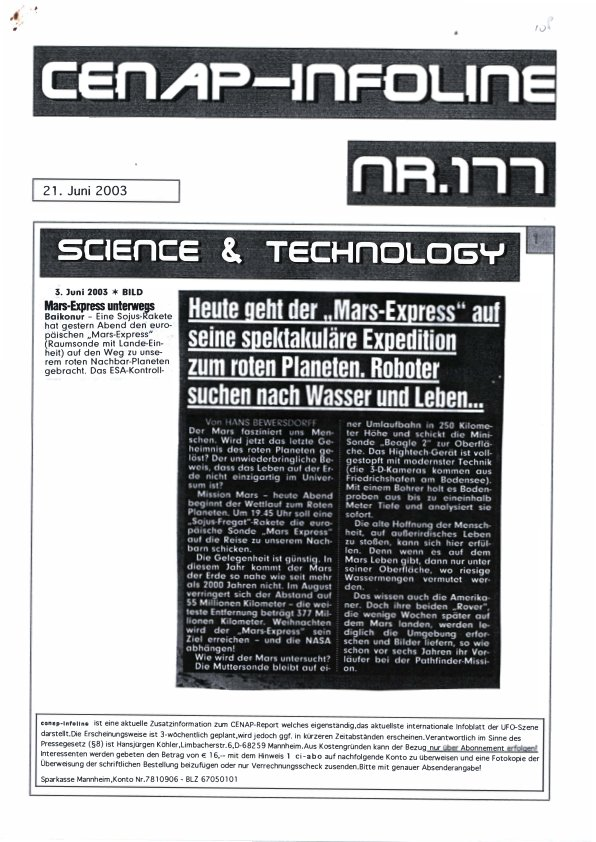

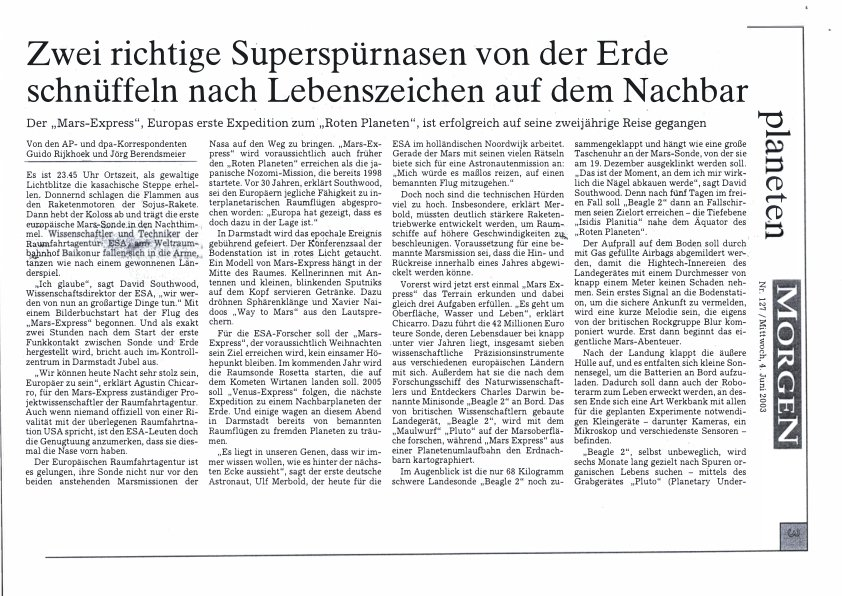

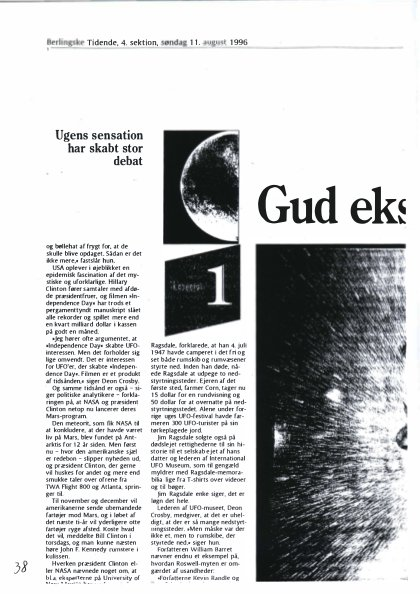

In [14]:
for i in indices:
    display(dataset[i]["image"])